In [1]:
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.util.img_processing import resize_cube
from heeps.util.freq_decomp import conv_kernel, spatial
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load NCPAs and masks

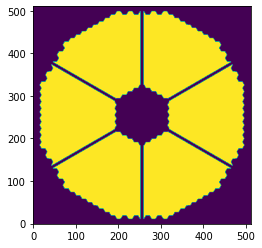

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files')))
folder = 'wavefront/cbw/20221006'
filename = os.path.join(folder, '%s/%s_rep_%s_field_%s.fits.gz')
tag = {'L':'LM', 'N2':'N'}
start_frames = [0, 13, 25, 32, 44 ]
start_times =['-2h00','-1h30','-1h00','-0h45','-0h15']
npupil_L = update_config(**dict(read_config(), band='L'))['npupil']
npupil_N = update_config(**dict(read_config(), band='N2'))['npupil']
npupil = {'L':npupil_L, 'N2':npupil_N}
scao_date = '20220512'
scao_cube = {'L':fits.getdata('wavefront/cfull/cube_Cfull_%s_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'%(scao_date, 'L', npupil_L)),
           'N2':fits.getdata('wavefront/cfull/cube_Cfull_%s_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'%(scao_date, 'N2', npupil_N))}
mask_L = fits.getdata('wavefront/cfull/mask_Cfull_%s_%s_%s.fits'%(scao_date, 'L', npupil_L)) > 0.5
mask_N = fits.getdata('wavefront/cfull/mask_Cfull_%s_%s_%s.fits'%(scao_date, 'N2', npupil_N)) > 0.5
mask = {'L':mask_L, 'N2':mask_N}
mask_M1 = fits.getdata('pupil/eso/mask_M1_511.fits') > 0.5
plt.imshow(mask_M1, origin='lower');

# Define functions

In [3]:
# André's array is 512x512, centered at the upper-right pixel.
# We want odd size, so we don't include the first row and column.
# 512 --> 511
def DIFF(band, rep, field):
    IMGP = filename%(tag[band], 'IMGP', rep, field)
    SCAP = filename%(tag[band], 'SCAP', rep, field)
    return np.float32(fits.open(IMGP)[0].data - fits.open(SCAP)[0].data)[1:,1:]

def get_median_field(band):
    nreps = 10
    nfields = 101
    rms_arr = np.empty((nreps, nfields))
    mu_rms_arr = []
    for i,rep in enumerate(range(1, nreps+1)):
        for j,field in enumerate(range(nfields)):
            ncpa = DIFF(band, rep, field)*1e9
            rms_arr[i,j] = np.std(ncpa[mask_M1])
        print('rep=%s, RMS: %s = %.2f nm (%s = %.2f nm) '%
              (rep, chr(956), np.mean(rms_arr[i]), chr(963), np.std(rms_arr[i])))
        mu_rms_arr.append(np.mean(rms_arr[i]))
#    reps = np.argsort(mu_rms_arr)[8:17] + 1
    reps = np.argsort(mu_rms_arr) + 1
    print('selected reps: %s'%reps)
    med_rep = np.argsort(mu_rms_arr)[nreps//2] + 1
    print('median rep: %s'%med_rep)
    med_field = np.argsort(rms_arr[med_rep - 1])[nfields//2]
    print('median field: %s'%med_field)
    return reps, med_rep, med_field

def spatial_filter(band, rep, field, cpp=10, nimg=511):
    pupil_img_size = 39.9988
    diam_nominal = 38.542
    nkernel = nimg*diam_nominal/pupil_img_size
    kernel = conv_kernel(nkernel, cpp)
    ncpa = DIFF(band, rep, field)*1e9
    allSF, LSF, HSF = spatial(ncpa*mask_M1, kernel, norm=True, verbose=True)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    plt.subplot(131); plt.title('all SF')
    im = plt.imshow(allSF*mask_M1, origin='lower')
    vmin, vmax = plt.gci().get_clim()
    plt.subplot(132); plt.title('LSF')
    plt.imshow(LSF*mask_M1, origin='lower', vmin=vmin, vmax=vmax)
    plt.subplot(133); plt.title('HSF')
    plt.imshow(HSF*mask_M1, origin='lower', vmin=vmin, vmax=vmax);

def get_ncpa_rep(band, rep, start_frame=38, start_time='-0h30', savefits=False):
    for i,field in enumerate(range(start_frame, start_frame+25)):
        ncpa = DIFF(band, rep, field)
        ncpa = resize_cube(ncpa, npupil[band])
        ncpa -= np.mean(ncpa[mask[band]]) # remove piston
        ncpa[~mask[band]] = 0             # mask with zeros
        stack = np.dstack([ncpa.T]*480).T
        if i == 0:
            cube = stack
        else:
            cube = np.vstack((cube, stack))
    if savefits is True:
        write_name = os.path.join(folder, 'ncpa/%s_'%tag[band] + 'rep_%s' + '_%s.fits'%start_time)
        if os.path.isfile(write_name%rep):
            print(write_name%rep + ' already exists.')
        else:
            fits.writeto(write_name%rep, cube, overwrite=True)
            print('rep %s %s NCPA: %.2f nm'%(rep, start_time, np.mean([np.std(x[mask[band]]) for x in cube*1e9])))
                

def create_scao_ncpas(band, reps, start_frame=38, start_time='-0h30'):
    write_name = os.path.join(folder, 'ncpa/cube_Cfull_%s_3600s_300ms_0piston_meters_cbw_ncpa_%s_%s_'% 
                    (scao_date, band, npupil[band]) + 'rep_%s' + '_%s.fits'%start_time)
    if os.path.isfile(write_name%reps[-1]):
        print(write_name%reps[-1] + ' already exists.')
    else:
        for rep in reps:
            cube = get_ncpa_rep(band, rep, start_frame=start_frame, start_time=start_time)
            cube += scao_cube[band]
            fits.writeto(write_name%rep, cube, overwrite=True)
            print('rep %s %s SCAO+NCPA: %.2f nm'%(rep, start_time, np.mean([np.std(x[mask[band]]) for x in cube*1e9])))

def create_talbots(band, reps, start_frame=38, start_time='-0h30'):
    write_name = os.path.join(folder, 'talbot/%s_'%tag[band] + 'rep_%s' + '_%s.fits'%start_time)
    if os.path.isfile(write_name%reps[-1]):
        print(write_name%reps[-1] + ' already exists.')
    else:
        for rep in reps:
            for i,field in enumerate(range(start_frame, start_frame+25)):
                IMGA = filename%(tag[band], 'IMGA', rep, field)
                talbot = np.float32(fits.open(IMGA)[0].data)[1:,1:]
                talbot = resize_cube(talbot, npupil[band])
                stack = np.dstack([talbot.T]*480).T
                if i == 0:
                    cube = stack
                else:
                    cube = np.vstack((cube, stack))
            fits.writeto(write_name%rep, cube, overwrite=True)
            print('rep %s %s Talbot'%(rep, start_time))

# 1/ Find median rep, and median field
### L band

rep=1, RMS: μ = 70.81 nm (σ = 0.17 nm) 
rep=2, RMS: μ = 134.01 nm (σ = 0.12 nm) 
rep=3, RMS: μ = 142.61 nm (σ = 0.14 nm) 
rep=4, RMS: μ = 132.86 nm (σ = 0.11 nm) 
rep=5, RMS: μ = 66.35 nm (σ = 0.10 nm) 
rep=6, RMS: μ = 117.20 nm (σ = 0.27 nm) 
rep=7, RMS: μ = 115.12 nm (σ = 0.09 nm) 
rep=8, RMS: μ = 97.66 nm (σ = 0.16 nm) 
rep=9, RMS: μ = 84.90 nm (σ = 0.23 nm) 
rep=10, RMS: μ = 151.85 nm (σ = 0.16 nm) 
selected reps: [ 5  1  9  8  7  6  4  2  3 10]
median rep: 6
median field: 24
rms(all SF) = 117.26 nm
rms(LSF) = 110.43 nm
rms(HSF) = 34.24 nm


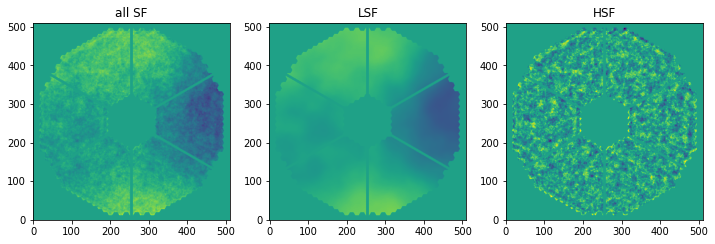

In [4]:
reps_L, med_rep_L, med_field_L = get_median_field('L')
spatial_filter('L', med_rep_L, med_field_L)

### N2 band

rep=1, RMS: μ = 142.72 nm (σ = 0.24 nm) 
rep=2, RMS: μ = 88.11 nm (σ = 0.16 nm) 
rep=3, RMS: μ = 73.06 nm (σ = 0.23 nm) 
rep=4, RMS: μ = 103.42 nm (σ = 0.19 nm) 
rep=5, RMS: μ = 89.03 nm (σ = 0.20 nm) 
rep=6, RMS: μ = 131.15 nm (σ = 0.74 nm) 
rep=7, RMS: μ = 227.53 nm (σ = 0.35 nm) 
rep=8, RMS: μ = 66.19 nm (σ = 0.18 nm) 
rep=9, RMS: μ = 87.94 nm (σ = 0.41 nm) 
rep=10, RMS: μ = 80.29 nm (σ = 0.25 nm) 
selected reps: [ 8  3 10  9  2  5  4  6  1  7]
median rep: 5
median field: 75
rms(all SF) = 88.97 nm
rms(LSF) = 78.89 nm
rms(HSF) = 35.52 nm


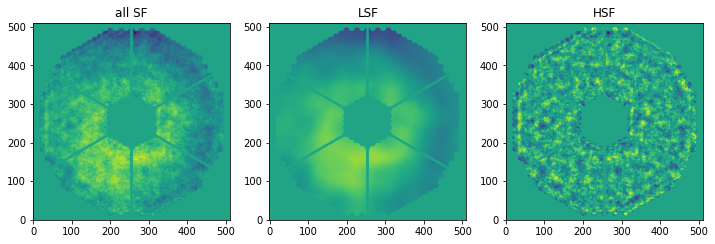

In [5]:
reps_N, med_rep_N, med_field_N = get_median_field('N2')
spatial_filter('N2', med_rep_N, med_field_N)

# 2/ Create cubes (1h staircase)

In [6]:
band = 'L'
med_rep = med_rep_L
reps = reps_L

In [7]:
get_ncpa_rep(band, med_rep, savefits=True)
create_scao_ncpas(band, reps)
create_talbots(band, reps)
for start_frame, start_time in zip(start_frames, start_times):
    create_scao_ncpas(band, [med_rep], start_frame=start_frame, start_time=start_time)
    create_talbots(band, [med_rep], start_frame=start_frame, start_time=start_time)

wavefront/cbw/20221006/ncpa/LM_rep_6_-0h30.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_L_285_rep_10_-0h30.fits already exists.
wavefront/cbw/20221006/talbot/LM_rep_10_-0h30.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_L_285_rep_6_-2h00.fits already exists.
wavefront/cbw/20221006/talbot/LM_rep_6_-2h00.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_L_285_rep_6_-1h30.fits already exists.
wavefront/cbw/20221006/talbot/LM_rep_6_-1h30.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_L_285_rep_6_-1h00.fits already exists.
wavefront/cbw/20221006/talbot/LM_rep_6_-1h00.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_L_285_rep_6_-0h45.fits already exists.
wavefront/cbw/20221006/talbot/LM_rep_6_-0h45.fits alrea

In [8]:
band = 'N2'
med_rep = med_rep_N
reps = reps_N

In [9]:
get_ncpa_rep(band, med_rep, savefits=True)
create_scao_ncpas(band, reps)
create_talbots(band, reps)
for start_frame, start_time in zip(start_frames, start_times):
    create_scao_ncpas(band, [med_rep], start_frame=start_frame, start_time=start_time)
    create_talbots(band, [med_rep], start_frame=start_frame, start_time=start_time)

wavefront/cbw/20221006/ncpa/N_rep_5_-0h30.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_N2_119_rep_7_-0h30.fits already exists.
wavefront/cbw/20221006/talbot/N_rep_7_-0h30.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_N2_119_rep_5_-2h00.fits already exists.
wavefront/cbw/20221006/talbot/N_rep_5_-2h00.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_N2_119_rep_5_-1h30.fits already exists.
wavefront/cbw/20221006/talbot/N_rep_5_-1h30.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_N2_119_rep_5_-1h00.fits already exists.
wavefront/cbw/20221006/talbot/N_rep_5_-1h00.fits already exists.
wavefront/cbw/20221006/ncpa/cube_Cfull_20220512_3600s_300ms_0piston_meters_cbw_ncpa_N2_119_rep_5_-0h45.fits already exists.
wavefront/cbw/20221006/talbot/N_rep_5_-0h45.fits already 